# Practice Session 7: ANOVA (Analysis of Variance)

In [ ]:
#!pip install researchpy

In [142]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import f, f_oneway, tukey_hsd

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import researchpy as rp

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [144]:
# From Practice Session 5: helper function for visualizing the F-distribution and rejection region of the ANOVA F-test
def plot_f_test(F_obs, df1, df2, alpha=0.05, alternative='greater', curve_color="#00bf63", obs_color="#c25bc7"):

    x = np.linspace(0, 12, 800)
    y = f.pdf(x, df1, df2)

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, color=curve_color, lw=2, label=f'F-distribution (df1={df1}, df2={df2})')

    if alternative == 'greater':
        # Right-tail critical value
        crit = f.ppf(1 - alpha, df1, df2)
        plt.fill_between(x, y, where=(x >= crit), alpha=0.35, color=curve_color, label=f'Rejection region (α={alpha}, right tail)')
        plt.axvline(crit, color='black', ls='--', lw=1, label=f'Critical F = {crit:.2f}')

    elif alternative == 'less':
        # Left-tail critical value
        crit = f.ppf(alpha, df1, df2)
        plt.fill_between(x, y, where=(x <= crit), alpha=0.35, color=curve_color, label=f'Rejection region (α={alpha}, left tail)')
        plt.axvline(crit, color='black', ls='--', lw=1, label=f'Critical F = {crit:.2f}')

    elif alternative == 'two-sided':
        # Two tails
        crit_low  = f.ppf(alpha/2, df1, df2)
        crit_high = f.ppf(1 - alpha/2, df1, df2)
        plt.fill_between(x, y, where=(x <= crit_low),  alpha=0.35, color=curve_color)
        plt.fill_between(x, y, where=(x >= crit_high), alpha=0.35, color=curve_color, label=f'Rejection regions (α={alpha}, two-sided)')
        plt.axvline(crit_low,  color='black', ls='--', lw=1, label=f'Critical F_low = {crit_low:.2f}')
        plt.axvline(crit_high, color='black', ls='--', lw=1, label=f'Critical F_high = {crit_high:.2f}')
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'.")

    # Observed F
    plt.axvline(F_obs, color=obs_color, ls='--', lw=2, label=f'Observed F = {F_obs:.2f}')

    plt.xlabel('F value')
    plt.ylabel('Probability density')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

## What is ANOVA?

Analysis of Variance (ANOVA) is a statistical method used to test whether there are significant differences between the means of more than two groups/samples.

> 💭 *But isn’t that what a t-test already does? Why not just use that?*

It’s true that a *t*-test can compare means - but only between two groups at a time.\
When we have more than two groups, it might seem reasonable to run multiple *t*-tests for all possible pairs.\
However, as we already discussed in **Practice Session 4**, each hypothesis test has a *"built-in"* probability of error (typically *α* = 0.05).\
Running many *t*-tests increases the overall error rate, meaning that with enough comparisons, you’re almost guaranteed to find at least one false positive purely by chance.\
> ANOVA avoids this inflation of Type I error by first testing a global null hypothesis: $H_0: \mu_1 = \mu_2 = \ldots = \mu_k$\
> If the global test is significant, we then perform post-hoc comparisons (e.g., Tukey’s test) to identify which specific groups differ.\
> In other words, ANOVA doesn't tell which of the many groups are different, but only that they are not the same.


> Before we look at **how ANOVA actually works**, we first need to be clear about the **types of variables** it involves.

---

**Independent and Dependent Variables**

Every ANOVA examines the relationship between two kinds of variables:

<table style="width:60%; table-layout:fixed;">
<thead>
<tr>
<th style="text-align:center; width:25%;">Type</th>
<th style="text-align:center; width:45%;">Description</th>
<th style="text-align:center; width:30%;">Environmental example</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center;">
<b>Independent variable</b><br>
<small style="color:gray;">(factor or treatment)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
A <i>categorical</i> variable (<i>nominal</i> or <i>ordinal</i>) that defines the <b>groups</b> or <b>conditions</b> being compared.  
Represents what we <b>manipulate</b> or <b>categorize</b> in the study.
</td>
<td style="vertical-align:top; text-align:left;">
<ul style="margin-top:0; margin-bottom:0;">
<li><b>Sampling site</b> (A, B, C)</li>
<li><b>Fertilizer type</b></li>
<li><b>Season</b></li>
</ul>
</td>
</tr>
<tr>
<td style="text-align:center;">
<b>Dependent variable</b><br>
<small style="color:gray;">(response)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
A <i>continuous</i> variable (<i>interval</i> or <i>ratio</i>) that we <b>measure</b> to determine whether it differs between groups.
</td>
<td style="vertical-align:top; text-align:left;">
<ul style="margin-top:0; margin-bottom:0;">
<li><b>Nitrate concentration</b></li>
<li><b>Soil pH</b></li>
<li><b>Chlorophyll content</b></li>
</ul>
</td>
</tr>
</tbody>
</table>



In other words:  
- The **independent variable** determines *how the data are grouped*  
- The **dependent variable** provides *the numerical values* whose means we compare  

> In ANOVA, we test whether the **mean of the dependent variable** differs significantly **between the levels of the independent variable**.  

---
As we already said, the primary goal of **ANOVA** is to test the **null hypothesis** that the population means of all groups are equal.  
The **alternative hypothesis** states that at least one group mean differs from the others.

When comparing group means, we can formally express the hypotheses as:
- **Null hypothesis ($H_0$):** All group means are equal  ($H_0: \mu_1 = \mu_2 = \ldots = \mu_k$)
- **Alternative hypothesis ($H_1$):** At least one group mean is different  ($H_1: \text{At least one pair of means differs, i.e. } \mu_i \neq \mu_j \text{ for some } i \neq j$)

ANOVA separates the total variation in the data into two components:
- **Between-group variance:** variation caused by differences **between** group means.  
- **Within-group variance:** variation caused by random differences **within** each group.

To evaluate whether the groups differ significantly, ANOVA calculates an **F-statistic**, which is the ratio of these two sources of variance: $F = \frac{\text{between-group variance}}{\text{within-group variance}}$\
A large *F*-value indicates that the variation between group means is much larger than the variation within groups - suggesting that the group differences are **statistically significant**.

---

**Types of ANOVA**

<table style="width:90%; table-layout:fixed;">
<thead>
<tr>
<th style="text-align:center; width:20%;">Type of ANOVA</th>
<th style="text-align:center; width:40%;">Purpose / When to use</th>
<th style="text-align:center; width:40%;">Environmental example</th>
</tr>
</thead>
<tbody>

<tr>
<td style="text-align:center;">
<b>One-way ANOVA</b><br>
<small style="color:gray;">(single factor)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
Tests whether one <b>categorical factor</b> has a significant effect on a continuous variable.  
Used when comparing more than two groups defined by a single factor.
</td>
<td style="vertical-align:top; text-align:left;">
<ul style="margin-top:0; margin-bottom:0;">
<li>Do three <b>lakes</b> differ in mean <b>phosphate concentration</b>?</li>
<li>Are <b>pollutant levels</b> different across <b>three soil types</b>?</li>
</ul>
</td>
</tr>

<tr>
<td style="text-align:center;">
<b>Two-way ANOVA</b><br>
<small style="color:gray;">(two factors, factorial design)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
Tests the effects of <b>two independent factors</b> and their possible <b>interaction</b> on a continuous variable.  
Reveals whether one factor’s effect depends on the level of the other.
</td>
<td style="vertical-align:top; text-align:left;">
<ul style="margin-top:0; margin-bottom:0;">
<li>Do <b>habitat type</b> (forest, meadow, wetland) and <b>season</b> (spring, summer) jointly affect <b>soil pH</b>?</li>
<li>Does <b>fertilizer type</b> interact with <b>irrigation level</b> to influence <b>plant growth</b>?</li>
</ul>
</td>
</tr>

<tr>
<td style="text-align:center;">
<b>One-way repeated-measures ANOVA</b><br>
<small style="color:gray;">(within-subject design)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
Used when the <b>same sampling sites or subjects</b> are measured repeatedly under different conditions or times.  
Accounts for the correlation between repeated observations on the same unit.
</td>
<td style="vertical-align:top; text-align:left;">
<ul style="margin-top:0; margin-bottom:0;">
<li>Does <b>nitrate concentration</b> in a river change <b>before, during, and after rainfall</b>?</li>
<li>Do <b>greenhouse gas fluxes</b> vary across <b>three sampling dates</b> at the same field site?</li>
</ul>
</td>
</tr>

<tr>
<td style="text-align:center;">
<b>Two-way repeated-measures ANOVA</b><br>
<small style="color:gray;">(treatment × time; one factor repeated)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
Used when there are <b>two factors</b> - typically a <b>between-subjects factor</b> (e.g., treatment or site) and a <b>within-subjects factor</b> (e.g., time or sampling event).  
Tests for the <b>main effects</b> of treatment and time, and their <b>interaction</b>, while accounting for repeated measurements on the same unit.
</td>
<td style="vertical-align:top; text-align:left;">
<ul style="margin-top:0; margin-bottom:0;">
<li>Do different <b>wetland restoration treatments</b> lead to distinct changes in <b>nitrate concentration</b> measured across several <b>months</b>?</li>
<li>Do <b>fertilizer types</b> influence changes in <b>soil respiration</b> monitored over <b>multiple time points</b>?</li>
</ul>
</td>
</tr>

</tbody>
</table>

---

#### One-Way ANOVA

A **one-way ANOVA** tests whether the **means of three or more independent groups** differ.  
It’s called *one-way* because there is **one categorical factor** (e.g., city, treatment, habitat) with two or more levels.


##### Example: PFOS levels in three cities
<div style="display: flex; align-items: flex-start; justify-content: space-between;">
  <div style="flex: 1; padding-right: 10px;">
Let’s apply the one-way ANOVA idea to a real environmental scenario.

Suppose PFOS (perfluorooctane sulfonate) concentrations were measured in blood samples of citizens from **Stockholm**, **New York**, and **Tokyo**.  
We want to test whether the **mean PFOS concentration** differs between these three cities.

| Stockholm | New York | Tokyo |
|:--------:|:--------:|:-----:|
| 1.2 | 1.7 | 1.3 |
| 0.8 | 1.5 | 1.5 |
| 1.1 | 2.0 | 1.4 |
| 0.7 | 2.1 | 1.0 |
| 0.9 | 1.1 | 1.8 |
| 1.1 | 0.9 | 1.4 |
| 1.5 | 2.2 | 1.9 |
| 0.8 | 1.8 | 0.9 |
| 1.6 | 1.3 | 1.9 |
| 0.9 | 1.5 | 1.8 |


> **We assume:**
> - Observations are **independent**.
> - Data within each city are **normally distributed**.
> - **Variances** across the three cities are approximately equal.

  </div>
  <div style="flex: 0 0 50%; text-align: right;">
    <img src="https://raw.githubusercontent.com/RaHub4AI/MI7032/refs/heads/main/Pictures/anova.png"
         alt="Workflow: choosing parametric vs. non-parametric tests"
         width="95%"
         style="border-radius: 8px;">
  </div>
</div>

**Hypotheses**\
We can now formally state the hypotheses for a one-way ANOVA:
- **Null hypothesis ($H_0$):**  The population means are equal across all cities. $H_0: \mu_{\text{Stockholm}} = \mu_{\text{New York}} = \mu_{\text{Tokyo}}$
- **Alternative hypothesis ($H_1$):** At least one city has a mean PFOS concentration that differs from the others. $H_1: \text{At least one } \mu_i \text{ differs from the others.}$
> If the *p*-value from ANOVA is below the significance level (e.g., $\alpha = 0.05$), we reject $H_0$ and conclude that PFOS concentrations are not the same across all three cities.

As we’ve already discussed, ANOVA works by splitting the **total variability** in the data into two main components: variation **between groups** and variation **within groups**.
- **SSB (Sum of Squares Between):** measures how much the **group means differ** from the overall (grand) mean.  
- **SSW (Sum of Squares Within):** measures how much the **individual values vary** around their own group mean.  
- **SST (Total Sum of Squares):** the **overall variability** in the dataset (equal to the sum of the two components, $\text{SST} = \text{SSB} + \text{SSW}$)

| Source of variation | Description | Formula | Degrees of freedom |
|:--------------------|:-------------|:----------|:------------------:|
| **Between groups (SSB)** | Variation caused by differences **between group means** | $\displaystyle \text{SSB} = \sum_{i=1}^{k} n_i (\bar{x}_i - \bar{x})^2$ | $df_B = k - 1$ |
| **Within groups (SSW)** | Variation caused by random fluctuations **within each group** | $\displaystyle \text{SSW} = \sum_{i=1}^{k} \sum_{j=1}^{n_i} (x_{ij} - \bar{x}_i)^2$ | $df_W = N - k$ |
| **Total (SST)** | Total variation in the entire dataset | $\text{SST} = \text{SSB} + \text{SSW}$ | $df_T = N - 1$ |

where:  
- $k$ = number of groups (cities)  
- $n_i$ = number of observations in group *i*  
- $\bar{x}_i$ = mean of group *i*  
- $\bar{x}$ = grand mean (mean of all data)  
- $N$ = total number of observations  

After computing sums of squares (SS) and degrees of freedom (df), we calculate **mean squares** (MS) and the **F-statistic**:

| Source | SS | df | MS | F | 
|:--|:--:|:--:|:--:|:--:|
| Between groups | SSB | $k-1$ | $\text{MSB} = \frac{\text{SSB}}{k-1}$ | $\displaystyle F = \frac{\text{MSB}}{\text{MSW}}$ |
| Within groups | SSW | $N-k$ | $\text{MSW} = \frac{\text{SSW}}{N-k}$ | – |
| Total | SST | $N-1$ | – | – |

If the observed $F$ is **large enough** (i.e., $p < \alpha$), we reject $H_0$ and conclude that **not all city means are equal**.


**Manual computation**

1. **Descriptive statistics**
    - $\bar x_{\text{Stockholm}}=1.06,\quad$
    - $\bar x_{\text{New York}}=1.61,\quad$
    - $\bar x_{\text{Tokyo}}=1.49,\quad$
    - $\bar x\_{\text{grand}}=1.387$

    | Group      | $n_i$ | Mean $(\bar x_i)$ | Sample var $(s_i^2)$ |
    |:-----------|:-------:|:-----------------:|:--------------------:|
    | Stockholm  | 10 | 1.06 | 0.0916 |
    | New York   | 10 | 1.61 | 0.1854 |
    | Tokyo      | 10 | 1.49 | 0.1299 |
    | **Total**  | 30 | 1.387 (grand mean) | – |


2. **Between-groups sum of squares (SSB)**
    - $\text{SSB} = \sum_{i=1}^{3} n_i\,(\bar x_i-\bar x)^2 = 10(1.06-1.387)^2 + 10(1.61-1.387)^2 + 10(1.49-1.387)^2 = 1.6727$

3. **Within-groups sum of squares (SSW)**\
    The within-group variation measures how far each observation deviates from its **own group mean**:
      - $\text{SSW} = \sum_{i=1}^{3}\sum_{j=1}^{n_i} (x_{ij}-\bar x_i)^2$
    > 
    > Let’s show the calculation for **Stockholm** as an example.
    >
    > For Stockholm, $\bar x_{\text{Stockholm}} = 1.06$:
    >
    > $\text{SSW}_{\text{Stockholm}} = (1.2-1.06)^2 + (0.8-1.06)^2 + (1.1-1.06)^2 + (0.7-1.06)^2 + (0.9-1.06)^2 + (1.1-1.06)^2 + (1.5-1.06)^2 + (0.8-1.06)^2 + (1.6-1.06)^2 + (0.9-1.06)^2 = 0.8240$  
    >
    > We repeat the same calculation for the other two cities:
    >     - $\text{SSW}_{\text{New York}} = 1.6690$
    >     - $\text{SSW}_{\text{Tokyo}} = 1.1690$

    Finally, summing them gives the total within-group sum of squares:
      - $\text{SSW} = \sum_{i=1}^{3}\sum_{j=1}^{n_i} (x_{ij}-\bar x_i)^2 = 0.8240\;(\text{Stockholm})\;+\;1.6690\;(\text{New York})\;+\;1.1690\;(\text{Tokyo}) = 3.6620$

4. **Totals and degrees of freedom**
    - $\text{SST}=\text{SSB}+\text{SSW}=5.3347$
    - $df_B=k-1=2$
    - $df_W=N-k=27$
    - $df_T=N-1=29$

5. **Mean squares**
    - $\text{MSB}=\frac{1.6727}{2}=0.8363$
    - $\text{MSW}=\frac{3.6620}{27}=0.13563$

    | Source           | SS       | df | MS       | F      | p-value   |
    |:-----------------|:---------|:--:|:---------|:------:|:---------:|
    | **Between** | 1.6727  |  2 | 0.8363  | **?** | **?** |
    | **Within**   | 3.6620  | 27 | 0.13563 | –      | –         |
    | **Total**            | 5.3347  | 29 | –       | –      | –         |

6. **Test statistic (F)**
   - $F=\frac{0.8363}{0.13563}=6.1663$

We now have our **test statistic**.   
The question is: *is this much between-group variation unusually large compared to within-group noise*?  
To answer that, we compare $F_{\text{obs}}$ to the **critical value** from the **F-distribution** with
- numerator $\text{df} =\;k-1=2$ and  
- denominator $\text{df} =\;N-k=27$.

For a right-tailed test at $\alpha=0.05$, the critical value is $F_{\text{crit}} = F^{-1}_{1-\alpha}(2, 27)$, and we **reject $H_0$** if $F_{\text{obs}} \ge F_{\text{crit}}$.\
Equivalently, we can use the **p-value**: $p=\Pr(F_{(2,27)}\ge 6.1663)$.  

> **Why right-tailed?**  
> The *F*-statistic is a *ratio of variances* - specifically, the variance **between groups** divided by the variance **within groups**.  
> Under the null hypothesis (no true difference between means), both variances should be roughly equal, and $F$ will be close to 1.  
> Only when the **between-group variance becomes much larger** than expected by chance does $F$ take on *large* values, providing evidence **against $H_0$**.  
> Therefore, the rejection region lies **in the right tail** of the *F*-distribution.

Let’s compute the exact critical value and **visualize** the rejection region together with the observed statistic (using the helper from Practice Session 5).

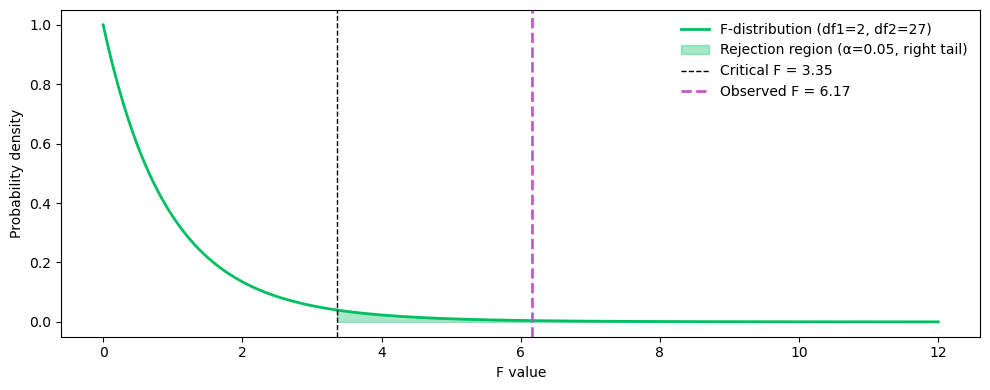

In [148]:
plot_f_test(6.1663, 2, 27, alpha=0.05, alternative='greater')

As we see in the plot, the **observed F-value (6.17)** lies well **inside the shaded rejection region** on the right tail of the *F*-distribution.  
This means the variation **between city means** is much larger than would be expected by random chance alone.  
Therefore, we **reject the null hypothesis** and conclude that **mean PFOS concentrations differ significantly between at least two of the cities**.

However, in practice, we often base this decision on the **p-value**, which we compare to our chosen ***α*-level** (commonly 0.05).  
For an ANOVA *F*-test, the *p*-value represents the **probability of obtaining an *F*-statistic at least as large as the observed one**, assuming that all group means are truly equal: $p \;=\; \Pr\!\big(F_{(df_1,df_2)} \ge F_{\text{obs}}\big)$.

> *Recall:* \
> The **Cumulative Distribution Function (CDF)** gives the probability that a random variable is *less than or equal* to a certain value: $P(F \le F_{\text{obs}}) = \text{CDF}(F_{\text{obs}})$\
> To get the **right-tail probability** - the *p-value* - we subtract this from 1: $p = 1 - \text{CDF}(F_{\text{obs}})$


In [13]:
p_value = 1 - f.cdf(6.1663, 2, 27)
print(f'p-value = {p_value:.5f}')

p-value = 0.00623


Based on the calculations: $p=\Pr\!\left(F_{(2,27)}\ge 6.1663\right)=0.00623$ 
Since $p = 0.00623 < \alpha = 0.05$, the likelihood of obtaining such a large *F*-statistic under the null hypothesis is very small.  
We therefore **reject $H_0$** and conclude that **PFOS concentrations differ significantly among the three cities**.

| Source           | SS       | df | MS       | F      | p-value   |
|:-----------------|:---------|:--:|:---------|:------:|:---------:|
| **Between** | 1.6727  |  2 | 0.8363  | **6.1663** | **0.00623** |
| **Within**   | 3.6620  | 27 | 0.13563 | –      | –         |
| **Total**            | 5.3347  | 29 | –       | –      | –         |


> Next, we’ll replicate this result using Python (`scipy.stats.f_oneway`) to verify the manual calculations.


In [17]:
three_cities = pd.DataFrame({'stockholm': [1.2, 0.8, 1.1, 0.7, 0.9, 1.1, 1.5, 0.8, 1.6, 0.9],
                             'new_york': [1.7, 1.5, 2.0, 2.1, 1.1, 0.9, 2.2, 1.8, 1.3, 1.5],
                             'tokyo': [1.3, 1.5, 1.4, 1.0, 1.8, 1.4, 1.9, 0.9, 1.9, 1.8]})
three_cities.describe()

,stockholm,new_york,tokyo
count,10.000000,10.000000,10.000000
mean,1.060000,1.610000,1.490000
std,0.302581,0.430633,0.360401
min,0.700000,0.900000,0.900000
25%,0.825000,1.350000,1.325000
50%,1.000000,1.600000,1.450000
75%,1.175000,1.950000,1.800000
max,1.600000,2.200000,1.900000


In [24]:
'''Converting data from wide to long format
Each observation now includes two columns:
'city'  → identifying which group (Stockholm, New York, or Tokyo)
'pfos'  → containing the measured PFOS concentration value'''
three_cities_long = three_cities.melt(var_name='city', value_name='pfos')

# Displaying overall summary statistics (across all cities combined)
display(three_cities_long.describe())

# Displaying summary statistics separately for each city
display(three_cities_long.groupby('city').describe())

,pfos
count,30.000000
mean,1.386667
std,0.428899
min,0.700000
25%,1.025000
50%,1.400000
75%,1.775000
max,2.200000


pfos                                              
          count  mean       std  min    25%   50%    75%  max
city                                                         
new_york   10.0  1.61  0.430633  0.9  1.350  1.60  1.950  2.2
stockholm  10.0  1.06  0.302581  0.7  0.825  1.00  1.175  1.6
tokyo      10.0  1.49  0.360401  0.9  1.325  1.45  1.800  1.9

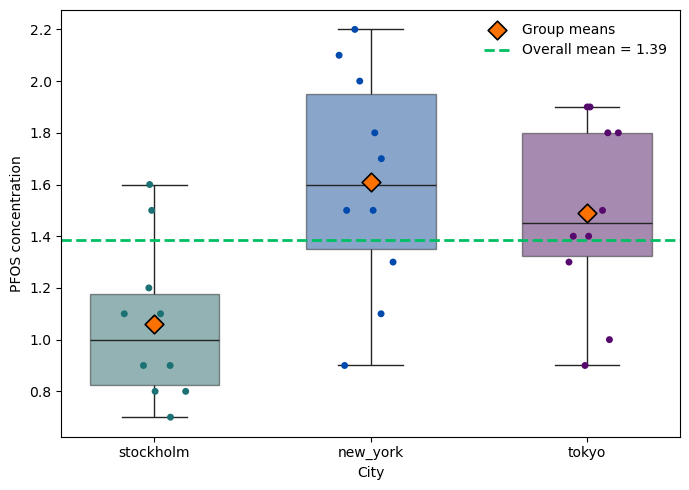

In [46]:
# Visualizing the data
# Defining custom colors for the boxplots and means
colors = ['#1b7173', '#004aad', '#570a6d']
mean_color = '#fc7202'   # group means
grand_color = '#00bf63'  # overall mean

# Choosing a consistent categorical order (matching the original wide DataFrame columns)
order = list(three_cities.columns)  # ['stockholm', 'new_york', 'tokyo']

# Building a palette that maps each city to its color (and preserves order)
palette = dict(zip(order, colors))

# Computing the overall (grand) mean
grand_mean = three_cities_long['pfos'].mean()

# Computing group means and reindexing to the chosen order (so plotting aligns)
group_means = (three_cities_long.groupby('city')['pfos'].mean().reindex(order))

# Creating the boxplot with a fixed order and matching palette
plt.figure(figsize=(7, 5))

ax = sns.boxplot(data=three_cities_long, x='city', y='pfos', order=order, palette=palette, width=0.6, fliersize=4, boxprops={'alpha': 0.5}, showmeans=False)

sns.stripplot(data=three_cities_long, x='city', y='pfos', order=order, palette=palette, jitter=0.15, size=5)

# Getting x positions that seaborn used for these categories
xpos = np.arange(len(order))

# Adding group means as orange diamond markers on top (matching the same x positions)
plt.scatter(xpos, group_means.values, color=mean_color, s=90, marker='D', zorder=5, edgecolor='black', linewidth=1.2, label='Group means')

# Adding the overall (grand) mean as a dashed horizontal line
plt.axhline(grand_mean, color=grand_color, linestyle='--', lw=2, label=f'Overall mean = {grand_mean:.2f}')

# Labeling and finishing
plt.xlabel('City')
plt.ylabel('PFOS concentration')
plt.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

In [51]:
# Performing ANOVA (between the three independent groups)
anova_f_statistic, anova_p_value = f_oneway(three_cities.stockholm, three_cities.new_york, three_cities.tokyo)
print(f"One-way ANOVA: F = {anova_f_statistic:.4f}, p = {anova_p_value:.5f}")

One-way ANOVA: F = 6.1663, p = 0.00623


Using `scipy.stats.f_oneway`, we obtain ***F* = 6.1663** and ***p* = 0.00623** - **exactly the same** values as in our **manual calculation**.  
This confirms that the **between‐group variation** (differences between city means) is large relative to the **within‐group variation**, yielding a small *p*-value.

**Conclusion from ANOVA:**  
We reject $H_0$ and conclude that **mean PFOS concentrations are not equal** across the three cities.

> However, the one-way ANOVA is a **global test**: it tells us that **not all means are equal**, but it does **not** tell us **which cities differ** (it could be one pair, two pairs, or all three).


#### Post-hoc testing: Tukey’s HSD

To find out **which pairs of cities** differ, we use a **post-hoc multiple-comparisons** procedure.  
A common choice is **Tukey’s Honest Significant Difference (HSD)** test:
- Compares **all pairs of group means** while **controlling the family-wise error rate** (FWER) at the chosen $\alpha$.  
- Provides **mean differences**, **adjusted *p*-values**, and **confidence intervals** for each pair.  
- ppropriate when group sizes are equal or nearly equal, and the assumption of equal variances (homoscedasticity) holds reasonably well (as we assumed in this case).

**Hypotheses per pair (e.g., New York vs Stockholm):**  
 - $H_0:\ \mu_{\text{NY}} - \mu_{\text{Stockholm}} = 0$
 - $H_1:\ \mu_{\text{NY}} - \mu_{\text{Stockholm}} \ne 0$

We can run Tukey’s HSD test using either the `Statsmodels` or `SciPy` library - both implement the same statistical procedure but differ in syntax and output format.
Next, we’ll try both approaches to see how their results compare.

In [55]:
'''SciPy
Input format: pass each group's data as a separate 1D array (order matters).
SciPy prints pairwise comparisons using 0-based indices that correspond to the input order you provide here: (0 = stockholm, 1 = new_york, 2 = tokyo).'''
result_tukey_scipy = tukey_hsd(three_cities.stockholm, three_cities.new_york, three_cities.tokyo)
print(result_tukey_scipy)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.550     0.007    -0.958    -0.142
 (0 - 2)     -0.430     0.038    -0.838    -0.022
 (1 - 0)      0.550     0.007     0.142     0.958
 (1 - 2)      0.120     0.749    -0.288     0.528
 (2 - 0)      0.430     0.038     0.022     0.838
 (2 - 1)     -0.120     0.749    -0.528     0.288



In [57]:
'''Statsmodels
Input format: long-form DataFrame with a numeric response and a categorical factor.
pairwise_tukeyhsd() returns a tidy summary table with group names, meandiff, adjusted p-values, simultaneous CIs, and a boolean 'reject' column.'''
result_tukey_statstmodels = pairwise_tukeyhsd(endog=three_cities_long.pfos, groups=three_cities_long.city, alpha=0.05)
print(result_tukey_statstmodels)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 new_york stockholm    -0.55 0.0067 -0.9584 -0.1416   True
 new_york     tokyo    -0.12 0.7489 -0.5284  0.2884  False
stockholm     tokyo     0.43 0.0375  0.0216  0.8384   True
----------------------------------------------------------


> *Notes:*
> - The `SciPy` printout indexes groups by the **input order**: `(0 = stockholm, 1 = new_york, 2 = tokyo)`.  
    The columns are the same information as Statsmodels (mean difference, adjusted *p*-value, and 95% CI), just shown with numeric indices.
> - The `Statsmodels` summary is **easier to read** in reporting contexts: it shows **group names**, the **mean difference**, **p-adj**, the **95% CI**, and a clear **reject** flag.\
> 
> As we can see from the numbers, **both implementations produce the same results**; they only differ in presentation.  
>
> *Personal preference: I use the `Statsmodels` version because the output is clearer and it fits neatly with the long-format workflow used for ANOVA and plotting.*


*Conclusion:* There are significant differences for the pairs New York vs Stockholm and Tokyo vs Stockholm (both reject = True). The pair New York vs Tokyo is not significant (reject = False).

#### Two-Way ANOVA
A two-way ANOVA extends the one-way design by examining the effects of two categorical factors simultaneously on a continuous outcome.
This allows us not only to test the individual (main) effects of each factor but also whether the factors interact - meaning that the effect of one depends on the level of the other.
For example, in environmental chemistry, you might study how pH and column type jointly influence compound retention time in liquid chromatography.

Using a two-way ANOVA, we can answer three key questions:
- Does Factor 1 have a significant effect on the dependent variable?
- Does Factor 2 have a significant effect on the dependent variable?
- Is there an interaction between Factor 1 and Factor 2?


##### Example: Effect of Sunlight and Watering on Plant Growth
A botanist investigates how **sunlight exposure** (None / Low / Medium / High) and **watering frequency** (Daily / Weekly) influence plant height (cm).
She grows **40 plants** (5 per treatment combination) for two months under controlled conditions and records the resulting heights:

| Watering \ Sun | None | Low | Medium | High |
|:--|:--:|:--:|:--:|:--:|
| **Daily**  | 4.8, 4.4, 3.2, 3.9, 4.4 | 5.0, 5.2, 5.6, 4.3, 4.8 | 6.4, 6.2, 4.7, 5.5, 5.8 | 6.3, 6.4, 5.6, 4.8, 5.8 |
| **Weekly** | 4.4, 4.2, 3.8, 3.7, 3.9 | 4.9, 5.3, 5.7, 5.4, 4.8 | 5.8, 6.2, 6.3, 6.5, 5.5 | 6.0, 4.9, 4.6, 5.6, 5.5 |

**Factors**  
- *Factor A*: Watering frequency (*a* = 2 levels: Daily, Weekly)  
- *Factor B*: Sunlight exposure (*b* = 4 levels: None, Low, Medium, High)  
- *Replicates per cell*: $n=5$ → $N = abn = 40$

**Hypotheses**\
In this experiment, we test whether plant height depends on watering frequency, sunlight exposure, or their interaction.
The hypotheses for each effect are summarized below:

<table style="width:80%; table-layout:fixed;">
<thead>
<tr>
<th style="text-align:center; width:25%;">Effect</th>
<th style="text-align:center; width:37%;">Null hypothesis (<i>H</i><sub>0</sub>)</th>
<th style="text-align:center; width:38%;">Alternative hypothesis (<i>H</i><sub>1</sub>)</th>
</tr>
</thead>
<tbody>

<tr>
<td style="text-align:center; vertical-align:top;">
<b>Watering frequency (Factor A)</b><br>
<small style="color:gray;">(Daily vs Weekly)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
There is <b>no difference</b> in average plant height for any watering frequency (Daily vs Weekly).
</td>
<td style="text-align:justify; vertical-align:top;">
There <b>is a difference</b> in average plant height by watering frequency.
</td>
</tr>

<tr>
<td style="text-align:center; vertical-align:top;">
<b>Sunlight exposure (Factor B)</b><br>
<small style="color:gray;">(None, Low, Medium, High)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
There is <b>no difference</b> in average plant height for any sunlight level (None, Low, Medium, High).
</td>
<td style="text-align:justify; vertical-align:top;">
There <b>is a difference</b> in average plant height by sunlight level.
</td>
</tr>

<tr>
<td style="text-align:center; vertical-align:top;">
<b>Interaction (A × B)</b><br>
<small style="color:gray;">(Watering × Sunlight)</small>
</td>
<td style="text-align:justify; vertical-align:top;">
The effect of one factor (watering) on average plant height <b>does not depend</b> on the effect of the other factor (sunlight).
</td>
<td style="text-align:justify; vertical-align:top;">
There <b>is an interaction effect</b> between watering frequency and sunlight exposure on average plant height.
</td>
</tr>

</tbody>
</table>


**Manual computation**

*Notations:*
- $\bar{y}$ – grand mean  
- $\bar{y}_{i\cdot}$ – row mean (watering level *i*)  
- $\bar{y}_{\cdot j}$ – column mean (sunlight level *j*)  
- $\bar{y}_{ij}$ – cell mean (watering *i*, sunlight *j*)  
- $y_{ijk}$ – *k*th observation in cell (*i*, *j*)  
- $a=2$, $b=4$, $n=5$, $N=40$


1. **Cell means, marginal means, and grand mean**
  - Cell means (Daily row first):
    |        | None | Low | Medium | High |
    |:------:|:---:|:---:|:------:|:----:|
    | Daily  | 4.14 | 4.98 | 5.72 | 5.78 |
    | Weekly | 4.00 | 5.22 | 6.06 | 5.32 |

  - Marginal means
    - Watering (A): $\bar y_{Daily\cdot} = 5.155$,  $\bar y_{Weekly\cdot} = 5.150$
    - Sunlight (B): $\bar y_{\cdot None} = 4.07$, $\bar y_{\cdot Low} = 5.10$, $\bar y_{\cdot Medium} = 5.89$, $\bar y_{\cdot High} = 5.55$

  - Grand mean: $\bar y = 5.1525$
    *(All means rounded to 2–3 decimals for readability; exact values used in sums of squares.)*

2. **Sums of squares decomposition**
    We partition the total variability: $\mathrm{SST}=\mathrm{SSA}+\mathrm{SSB}+\mathrm{SSAB}+\mathrm{SSW},$ where:
      - **SSA** (Watering, A): $\mathrm{SSA}= b\,n \sum_{i=1}^{a}\left(\bar y_{i\cdot}-\bar y\right)^2$
            Numbers (with $b\,n = 4\times5 = 20$):\
            $\mathrm{SSA} = 20[(5.155 - 5.1525)^2 + (5.150 - 5.1525)^2] = 20[0.0025^2 + (-0.0025)^2]= 20(6.25\times10^{-6} + 6.25\times10^{-6}) = \mathbf{0.00025}$  
            *(Row means are almost identical → very small SSA.)*
      - **SSB** (Sunlight, B): $\mathrm{SSB}= a\,n \sum_{j=1}^{b}\left(\bar y_{\cdot j}-\bar y\right)^2$
            Numbers (with $a\,n = 2\times5 = 10$):\
              $\mathrm{SSB} = 10[(4.07-5.1525)^2 + (5.10-5.1525)^2 + (5.89-5.1525)^2 + (5.55-5.1525)^2] = 10[1.1718 + 0.0028 + 0.5439 + 0.1580] = \mathbf{18.76475}$  
              *(Large spread across sunlight levels → dominant source of variance.)*
      - **SSAB** (Interaction): $\mathrm{SSAB}= n \sum_{i=1}^{a} \sum_{j=1}^{b} \left(\bar y_{ij}-\bar y_{i\cdot}-\bar y_{\cdot j}+\bar y\right)^2$\
            Let $\Delta_{ij} = \bar{y}_{ij} - \bar{y}_{i\cdot} - \bar{y}_{\cdot j} + \bar{y}$.\
            A few examples (then all 8 are summed):
            
          | Cell | $\bar{y}_{ij}$ | $\bar{y}_{i\cdot}$ | $\bar{y}_{\cdot j}$ | $\Delta_{ij}$ | $n\Delta_{ij}^2$ |
          |:--|:--:|:--:|:--:|:--:|:--:|
          | Daily × None | 4.14 | 5.155 | 4.07 | 0.0675 | $5\times0.0675^2=0.0228$ |
          | Daily × Medium | 5.72 | 5.155 | 5.89 | -0.1725 | $5\times0.1725^2=0.1488$ |
          | Weekly × Medium | 6.06 | 5.150 | 5.89 | 0.1725 | $5\times0.1725^2=0.1488$ |
          | Weekly × High | 5.32 | 5.150 | 5.55 | -0.2275 | $5\times0.2275^2=0.2589$ |

          Adding all 8 cell contributions gives: $\mathrm{SSAB} = \mathbf{1.01075}$

      - **SSW** (Within/error): $\mathrm{SSW}= \sum_{i,j}\sum_{k=1}^{n}(y_{ijk}-\bar y_{ij})^2$\
          Examples:
          - Daily × None (values 4.8, 4.4, 3.2, 3.9, 4.4, $\bar{y}_{DN}=4.14$): $\sum(y - \bar{y}_{DN})^2 = (4.8-4.14)^2 + (4.4-4.14)^2 + (3.2-4.14)^2 + (3.9-4.14)^2 + (4.4-4.14)^2 = 1.512$
          - Weekly × Low (values 4.9, 5.3, 5.7, 5.4, 4.8, $\bar{y}_{WL}=5.22$): $\sum(y - \bar{y}_{WL})^2 = (4.9-5.22)^2 + (5.3-5.22)^2 + (5.7-5.22)^2 + (5.4-5.22)^2 + (4.8-5.22)^2 = 0.548$
          
          Adding all 8 cell contributions yields: $\mathrm{SSW} = \mathbf{8.68400}$

    Total: $\mathrm{SST} = 28.45975$ and $\mathrm{SSA}+\mathrm{SSB}+\mathrm{SSAB}+\mathrm{SSW} = 28.45975$

3. **Degrees of freedom and mean squares**
    - $df_A=a-1=1$, $df_B=b-1=3$, $df_{AB}=(a-1)(b-1)=3$  
    - $df_W=a\,b\,(n-1)=2\cdot4\cdot4=32$  
    - $df_T=N-1=39$

    Mean squares:
      - $\mathrm{MSA}=\mathrm{SSA}/df_A=0.00025$
      - $\mathrm{MSB}=\mathrm{SSB}/df_B=6.25492$
      - $\mathrm{MSAB}=\mathrm{SSAB}/df_{AB}=0.33692$
      - $\mathrm{MSW}=\mathrm{SSW}/df_W=0.27138$

4. ***F*-statistics (rounded)**
    - $F_A=\frac{\mathrm{MSA}}{\mathrm{MSW}}=0.00092$
    - $F_B=\frac{\mathrm{MSB}}{\mathrm{MSW}}=23.049$
    - $F_{AB}=\frac{\mathrm{MSAB}}{\mathrm{MSW}}=1.242$

    Right-tailed *p*-values (with $df_1$ as above and $df_2=32$):
      - Watering (A): $p \approx 0.976$
      - Sunlight (B): $p \approx 3.9\times 10^{-8}$
      - Interaction (A×B): $p \approx 0.311$

| Source                | SS        | df | MS        | F       | p-value        |
|:----------------------|----------:|:--:|----------:|--------:|---------------:|
| Watering (A)          | 0.00025   |  1 | 0.00025   | 0.00092 | 0.976          |
| Sunlight (B)          | 18.76475  |  3 | 6.25492   | 23.049  | 3.9e-08        |
| A × B (Interaction)   | 1.01075   |  3 | 0.33692   | 1.242   | 0.311          |
| **Error (Within)**    | 8.68400   | 32 | 0.27138   |   —     | —              |
| **Total**             | 28.45975  | 39 | —         | —       | —              |

5. **Interpretation (α = 0.05)**
  - **Sunlight exposure (B)** has a **strong, statistically significant** effect on plant height (very small p-value).  
  - **Watering frequency (A)** shows **no evidence** of a main effect (p ≫ 0.05).  
    - **Interaction (A×B)** is **not significant** — the sunlight effect is similar under Daily and Weekly watering.

**Conclusion:** Plant height differs across **sunlight levels**, but not between **daily vs weekly** watering in this experiment, and there is **no interaction** detected.


> Below we’ll reproduce the manual results with Python:
> - building the dataset in **long format**,  
> - fitting a **two-way ANOVA with interaction**,  
> - printing a tidy **ANOVA table**, and  
> - **visualizing** the means and variability.


In [60]:
daily_none   = [4.8, 4.4, 3.2, 3.9, 4.4]
daily_low    = [5.0, 5.2, 5.6, 4.3, 4.8]
daily_med    = [6.4, 6.2, 4.7, 5.5, 5.8]
daily_high   = [6.3, 6.4, 5.6, 4.8, 5.8]

weekly_none  = [4.4, 4.2, 3.8, 3.7, 3.9]
weekly_low   = [4.9, 5.3, 5.7, 5.4, 4.8]   
weekly_med   = [5.8, 6.2, 6.3, 6.5, 5.5]  
weekly_high  = [6.0, 4.9, 4.6, 5.6, 5.5]

# Creating a long-format DataFrame
def make_block(vals, water, sun):
    return pd.DataFrame({"height": vals, "water": water, "sun": sun})

df = pd.concat([make_block(daily_none,  "Daily",  "None"),
                make_block(daily_low,   "Daily",  "Low"),
                make_block(daily_med,   "Daily",  "Medium"),
                make_block(daily_high,  "Daily",  "High"),
                make_block(weekly_none, "Weekly", "None"),
                make_block(weekly_low,  "Weekly", "Low"),
                make_block(weekly_med,  "Weekly", "Medium"),
                make_block(weekly_high, "Weekly", "High")], ignore_index=True)

# Checking a preview
df.head()

,height,water,sun
0,4.8,Daily,None
1,4.4,Daily,None
2,3.2,Daily,None
3,3.9,Daily,None
4,4.4,Daily,None


In [81]:
# Fitting the two-way ANOVA (OLS model) (with A×B)

model = smf.ols('height ~ C(water) * C(sun)', data=df).fit()

# Getting Type II ANOVA table (common for balanced designs)
anova_tbl = sm.stats.anova_lm(model, typ=2)
display(anova_tbl)

,sum_sq,df,F,PR(>F)
C(water),0.00025,1.0,0.000921,9.759750e-01
C(sun),18.76475,3.0,23.048979,3.898088e-08
C(water):C(sun),1.01075,3.0,1.241517,3.108977e-01
Residual,8.68400,32.0,NaN,NaN


In [62]:
# Computing cell means, row/column means, and grand mean
cell_means = df.groupby(['water','sun'])['height'].mean().unstack()
row_means  = cell_means.mean(axis=1)
col_means  = cell_means.mean(axis=0)
grand_mean = df['height'].mean()

# Assembling a display table with totals
display_tbl = cell_means.copy()
display_tbl.loc['Row mean'] = col_means.values
display_tbl['Row mean'] = pd.concat([row_means, pd.Series({'Row mean': grand_mean})])

# Displaying the table
display_tbl

sun,High,Low,Medium,None,Row mean
water,,,,,
Daily,5.78,4.98,5.72,4.14,5.1550
Weekly,5.32,5.22,6.06,4.00,5.1500
Row mean,5.55,5.10,5.89,4.07,5.1525


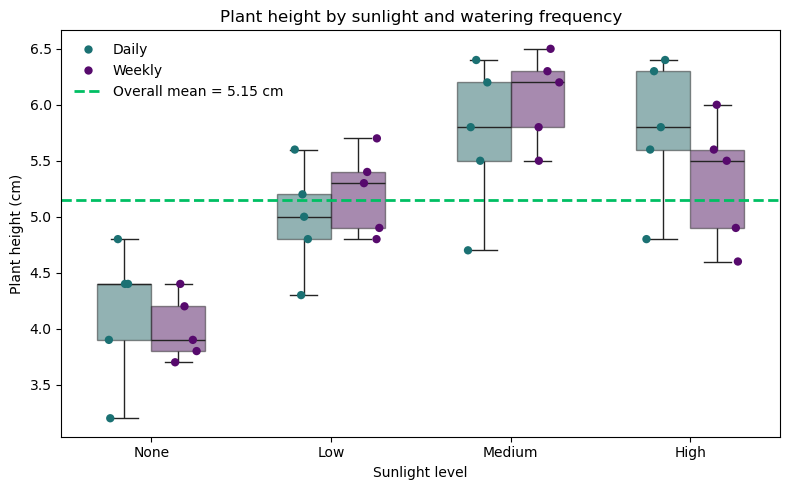

In [79]:
colors = ['#1b7173', '#570a6d']  # custom palette for watering levels
grand_mean = df['height'].mean()  # overall mean

plt.figure(figsize=(8, 5))

# Boxplot
sns.boxplot(data=df, x='sun', y='height', hue='water', palette=colors, width=0.6, fliersize=3, linewidth=1, boxprops={'alpha': 0.5})

# Overlay jittered points
sns.stripplot(data=df, x='sun', y='height', hue='water', palette=colors, dodge=True, jitter=0.15, size=6, alpha=1)

# Horizontal line for overall mean
plt.axhline(grand_mean, color='#00bf63', ls='--', lw=2, label=f'Overall mean = {grand_mean:.2f} cm')

# Axis labels and title
plt.xlabel('Sunlight level')
plt.ylabel('Plant height (cm)')
plt.title('Plant height by sunlight and watering frequency')

# Merge duplicate legend entries (from boxplot + stripplot)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon=False, loc='best')

plt.tight_layout()
plt.show()


> The boxplots show that:
> - Plant height clearly increases with **sunlight exposure** (from “None” to “Medium”), then plateaus slightly.
> - There’s **no consistent difference** between watering frequencies (green vs. purple boxes).
> - The dashed green line marks the **overall mean height** across all conditions (≈5.15 cm)

##### Including vs. Excluding the Interaction Term
In a two-way ANOVA, you can fit two types of models depending on your research question:
```python
# Model 1: With interaction (full factorial model)
model = smf.ols('height ~ C(water) * C(sun)', data=df).fit()

# Model 2: Without interaction (additive model)
model = smf.ols('height ~ C(water) + C(sun)', data=df).fit()
```
<table style="width:80%; table-layout:fixed;">
<thead>
<tr>
<th style="text-align:center; width:10%;">Model</th>
<th style="text-align:center; width:20%;">Formula meaning</th>
<th style="text-align:center; width:25%;">What it tests</th>
<th style="text-align:center; width:25%;">Typical use</th>
</tr>
</thead>
<tbody>

<tr>
<td style="text-align:center;">
<b>With interaction (<code>*</code>)</b><br>
<small style="color:gray;">Full factorial model</small>
</td>
<td style="text-align:justify; vertical-align:top;">
<code>C(water)*C(sun)</code> expands to <code>C(water)+C(sun)+C(water):C(sun)</code>
</td>
<td style="text-align:justify; vertical-align:top;">
Tests the <b>main effects</b> of both factors and whether the <b>effect of one depends on the other</b> (interaction).
</td>
<td style="text-align:justify; vertical-align:top;">
Used when you suspect that <b>sunlight and watering</b> may influence each other’s effects on growth.
</td>
</tr>

<tr>
<td style="text-align:center;">
<b>Without interaction (<code>+</code>)</b><br>
<small style="color:gray;">Additive model</small>
</td>
<td style="text-align:justify; vertical-align:top;">
<code>C(water)+C(sun)</code>
</td>
<td style="text-align:justify; vertical-align:top;">
Tests only the <b>main effects</b> of watering and sunlight, assuming their effects are <b>independent</b> (no interaction).
</td>
<td style="text-align:justify; vertical-align:top;">
Used when data or prior knowledge suggests that both factors act <b>independently</b>.
</td>
</tr>

</tbody>
</table>

Let’s now compare the two-way ANOVA results obtained from both models - one including the interaction term (C(water) * C(sun)) and one without it (C(water) + C(sun)).

In [82]:
model_without = smf.ols('height ~ C(water) + C(sun)', data=df).fit()
anova_tbl_without = sm.stats.anova_lm(model_without, typ=2)
print('With interaction', flush=True)
display(anova_tbl)

print('Without interaction', flush=True)
display(anova_tbl_without)

With interaction


,sum_sq,df,F,PR(>F)
C(water),0.00025,1.0,0.000921,9.759750e-01
C(sun),18.76475,3.0,23.048979,3.898088e-08
C(water):C(sun),1.01075,3.0,1.241517,3.108977e-01
Residual,8.68400,32.0,NaN,NaN


Without interaction


,sum_sq,df,F,PR(>F)
C(water),0.00025,1.0,0.000903,9.762038e-01
C(sun),18.76475,3.0,22.581509,2.594323e-08
Residual,9.69475,35.0,NaN,NaN


As we can see, the main conclusions remain the same: sunlight exposure has a strong effect on plant growth, while watering frequency on its own does not.\
However, the *p*-values differ slightly between the two models.\
*This happens because:*\
When we include the interaction term, part of the variation that was previously attributed to the main effects is now partitioned into the interaction.\
This changes the degrees of freedom and the error variance, which slightly alters the *F*- and *p*-values for the main effects.

*In other words:*\
Including the interaction makes the model more flexible (and realistic) - but also more complex.\
If the interaction is not significant, we can usually simplify the model by removing it and refitting the additive form.

*Note:*
There are two types of Two-Way ANOVA, depending on whether we have replicates (multiple measurements per factor combination) or not.
<table style="width:80%; table-layout:fixed;"> <thead> <tr> <th style="text-align:center; width:10%;">Type</th> <th style="text-align:center; width:30%;">Description</th> <th style="text-align:center; width:20%;">Environmental example</th> </tr> </thead> <tbody> <tr> <td style="text-align:center;"> <b>Two-Way ANOVA<br>without replication</b><br> <small style="color:gray;">(no repeated observations)</small> </td> <td style="text-align:justify; vertical-align:top;"> Each combination of factor levels (e.g., Location × Day) has <b>only one observation</b>. This design allows testing <b>main effects only</b> - the interaction between factors cannot be estimated. </td> <td style="vertical-align:top; text-align:left;"> <ul style="margin-top:0; margin-bottom:0;"> <li>Measuring <b>soil pH</b> once per combination of <b>land cover type</b> and <b>season</b>.</li> </ul> </td> </tr> <tr> <td style="text-align:center;"> <b>Two-Way ANOVA<br>with replication</b><br> <small style="color:gray;">(multiple observations per cell)</small> </td> <td style="text-align:justify; vertical-align:top;"> Each combination of factor levels contains <b>several replicate measurements</b>. This allows testing both <b>main effects</b> and the <b>interaction effect</b> between the two factors. </td> <td style="vertical-align:top; text-align:left;"> <ul style="margin-top:0; margin-bottom:0;"> <li>Measuring <b>microplastic deposition</b> several times per combination of <b>location</b> and <b>day</b>.</li> </ul> </td> </tr> </tbody> </table>

#### <font color="#fc7202">Task 1:</font>
You collected data on the number of microplastic particles deposited in samplers at four locations (A, B, C, D) over three consecutive days (1-3) (see below).

Use a two-way ANOVA to test the following:
1. Whether the sampling location affects the number of particles collected.
2. Whether the sampling day affects the number of particles collected.

*In this exercise, we assume that the standard assumptions of ANOVA are met.*

In [120]:
microplastics = pd.DataFrame({'day': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
                              'location': np.repeat(['A', 'B', 'C', 'D'], 3),
                              'particles': [84, 79, 83, 80, 77, 78, 83, 80, 80, 79, 79, 78]})

# Treat 'day' as ordered categorical (useful for plots later)
microplastics['day'] = pd.Categorical(microplastics['day'], categories=[1,2,3], ordered=True)

In [106]:
microplastics.describe()

,day,particles
count,12.000000,12.000000
mean,2.000000,80.000000
std,0.852803,2.215647
min,1.000000,77.000000
25%,1.000000,78.750000
50%,2.000000,79.500000
75%,3.000000,80.750000
max,3.000000,84.000000


In [116]:
by_day = microplastics.groupby('day')['particles'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    q1=lambda s: s.quantile(0.25),
    q3=lambda s: s.quantile(0.75),
    max='max',
    iqr=lambda s: s.quantile(0.75) - s.quantile(0.25)
).round(3)
display(by_day)

,count,mean,median,std,min,q1,q3,max,iqr
day,,,,,,,,,
1,4,81.50,81.5,2.380,79,79.75,83.25,84,3.50
2,4,78.75,79.0,1.258,77,78.50,79.25,80,0.75
3,4,79.75,79.0,2.363,78,78.00,80.75,83,2.75


In [123]:
# We can also use the `researchpy` package to quickly obtain detailed descriptive statistics (n, mean, SD, SE, CI, etc.) for each group - it’s great for summarizing datasets before ANOVA.
# Documentation: https://researchpy.readthedocs.io/en/latest/
rp.summary_cont(microplastics['particles'].groupby(microplastics['day']))

,N,Mean,SD,SE,95% Conf.,Interval
day,,,,,,
1,4,81.50,2.3805,1.1902,77.7121,85.2879
2,4,78.75,1.2583,0.6292,76.7478,80.7522
3,4,79.75,2.3629,1.1815,75.9901,83.5099


In [124]:
rp.summary_cont(microplastics['particles'].groupby(microplastics['location']))

,N,Mean,SD,SE,95% Conf.,Interval
location,,,,,,
A,3,82.0000,2.6458,1.5275,75.4276,88.5724
B,3,78.3333,1.5275,0.8819,74.5388,82.1279
C,3,81.0000,1.7321,1.0000,76.6973,85.3027
D,3,78.6667,0.5774,0.3333,77.2324,80.1009


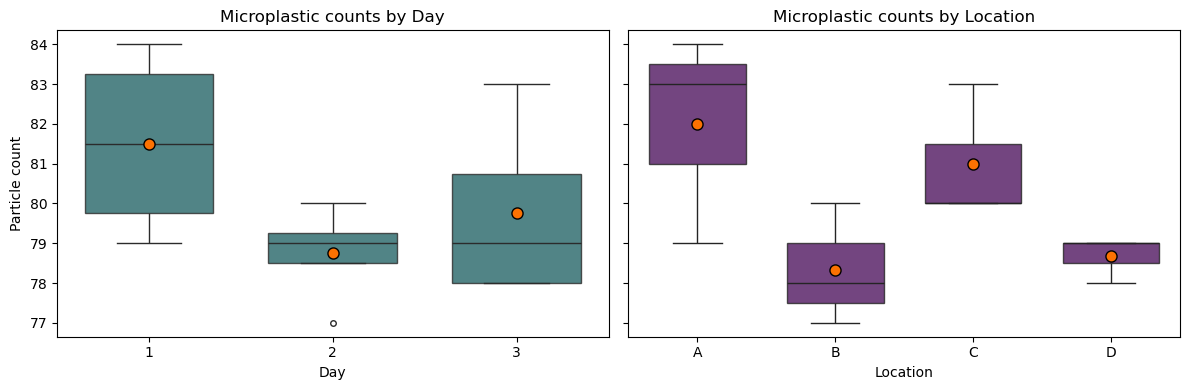

In [152]:
# Visualizing the data

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.boxplot(data=microplastics, x='day', y='particles', color= '#1b7173', width=0.7, fliersize=4, linewidth=1, ax=axes[0], showmeans=True, 
            boxprops={'alpha': 0.8}, meanprops={'marker': 'o', 'markerfacecolor': '#fc7202', 'markeredgecolor': 'black', 'markersize': 8, 'linestyle': 'none'})
axes[0].set_title('Microplastic counts by Day')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Particle count')

sns.boxplot(data=microplastics, x='location', y='particles',color = '#570a6d', width=0.7, fliersize=4, linewidth=1, ax=axes[1], showmeans=True,
            boxprops={'alpha': 0.8}, meanprops={'marker': 'o', 'markerfacecolor': '#fc7202', 'markeredgecolor': 'black', 'markersize': 8, 'linestyle': 'none'})
axes[1].set_title('Microplastic counts by Location')
axes[1].set_xlabel('Location')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [108]:
# Performing two-way ANOVA
model_microplastic = smf.ols('particles ~ C(day) + C(location)', data=microplastics).fit()
anova_tbl_microplastic= sm.stats.anova_lm(model_microplastic, typ=2)
display(anova_tbl_microplastic)


,sum_sq,df,F,PR(>F)
C(day),15.500000,2.0,4.728814,0.058482
C(location),28.666667,3.0,5.830508,0.032756
Residual,9.833333,6.0,NaN,NaN


In a two-way ANOVA, we obtain separate *p*-values for each independent variable (factor).\
Recall that for each factor, the null hypothesis ($H_0$) states that the group means are equal.\
In this case, using a significance level of $\alpha = 0.05$:
- For the factor `day` (*p* = 0.0585), we fail to reject $H_0$ → The mean number of collected particles does not differ significantly between days.
- For the factor `location` (*p* = 0.0328), we reject $H_0$ → The mean number of collected particles differs significantly between locations.

Thus, we conclude that sampling location has a significant effect on the number of microplastic particles collected, whereas sampling day does not.

#### <font color="#fc7202">Task 2:</font>
You return to the field and deploy **deposition samplers in triplicate** at each site for **three consecutive days**.  
Use a **two-way ANOVA with replication** to test:
1. whether you collect different amounts at different **locations**,  
2. whether you collect different amounts on different **days**, and  
3. whether there is any **interaction** between location and day.

*Data file:* `microplastics.tsv`  
*Assumption for this task:* *All standard ANOVA assumptions (independence, normality within cells, and homogeneity of variances) are considered satisfied.*

In [126]:
microplastics_rep = pd.read_csv('microplastics.tsv', sep='\t')
display(microplastics_rep.head())
display(microplastics_rep.describe())

,day,plast,location
0,Day 1,84,A
1,Day 1,82,A
2,Day 1,83,A
3,Day 2,84,A
4,Day 2,81,A


,plast
count,36.000000
mean,80.166667
std,2.580144
min,70.000000
25%,79.000000
50%,80.000000
75%,81.250000
max,84.000000


In [130]:
rp.summary_cont(microplastics_rep['plast'].groupby(microplastics_rep['location']))

,N,Mean,SD,SE,95% Conf.,Interval
location,,,,,,
A,9,82.2222,1.3944,0.4648,81.1504,83.2941
B,9,78.5556,3.3953,1.1318,75.9457,81.1654
C,9,81.4444,1.3333,0.4444,80.4196,82.4693
D,9,78.4444,1.0138,0.3379,77.6652,79.2237


In [131]:
rp.summary_cont(microplastics_rep['plast'].groupby(microplastics_rep['day']))

,N,Mean,SD,SE,95% Conf.,Interval
day,,,,,,
Day 1,12,81.1667,1.6422,0.4741,80.1232,82.2101
Day 2,12,79.5833,3.6794,1.0621,77.2456,81.9211
Day 3,12,79.7500,1.8153,0.5240,78.5966,80.9034


## <font color="#fc7202">🚫 Do NOT use boxplots with n≈3!!!!!
The next plot is a bad visualization of the data - with only 3 points, quartiles/IQR are meaningless and misleading.
</font>

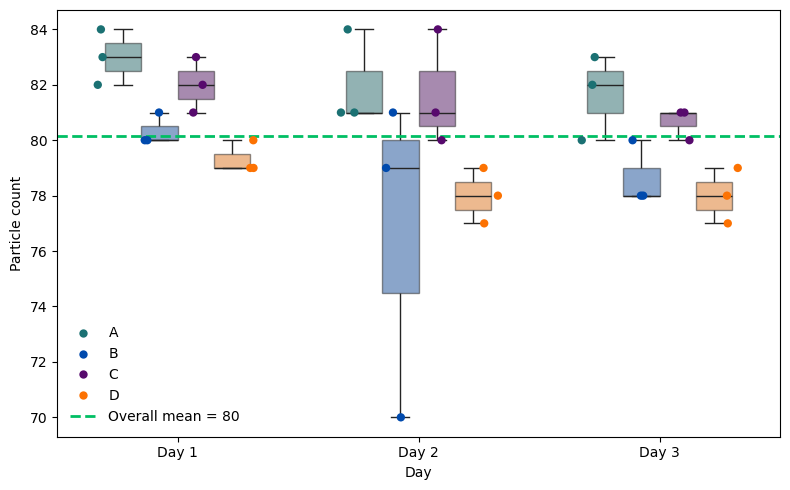

In [138]:
colors = ['#1b7173', '#004aad', '#570a6d', '#fc7202']
grand_mean = microplastics_rep['plast'].mean()

plt.figure(figsize=(8, 5))

# Boxplot
sns.boxplot(data=microplastics_rep, x='day', y='plast', hue='location', palette=colors, width=0.6, fliersize=3, linewidth=1, boxprops={'alpha': 0.5})

# Overlay jittered points
sns.stripplot(data=microplastics_rep, x='day', y='plast', hue='location', palette=colors, dodge=True, jitter=0.15, size=6, alpha=1)

# Horizontal line for overall mean
plt.axhline(grand_mean, color='#00bf63', ls='--', lw=2, label=f'Overall mean = {grand_mean:.0f}')

# Axis labels and title
plt.xlabel('Day')
plt.ylabel('Particle count')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon=False, loc='best')

plt.tight_layout()
plt.show()

The next visualization is more suitable in this case.

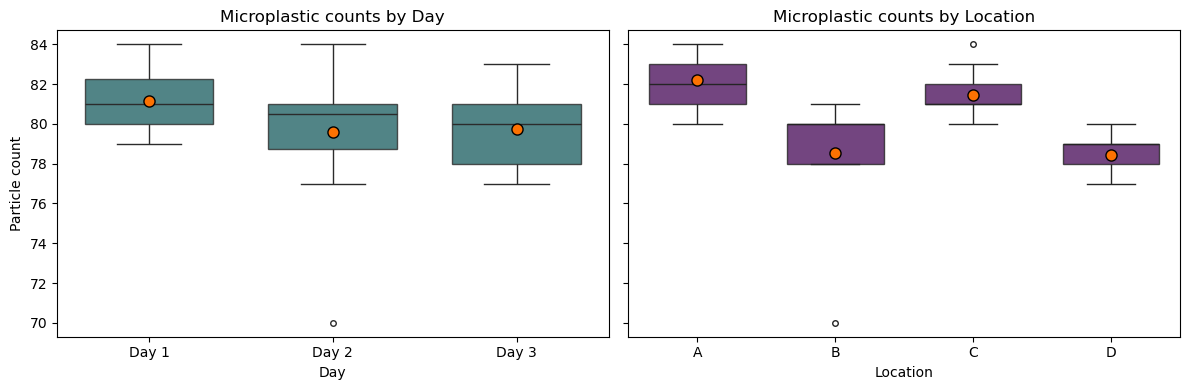

In [158]:
# Visualizing the data

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.boxplot(data=microplastics_rep, x='day', y='plast', color= '#1b7173', width=0.7, fliersize=4, linewidth=1, ax=axes[0], showmeans=True, 
            boxprops={'alpha': 0.8}, meanprops={'marker': 'o', 'markerfacecolor': '#fc7202', 'markeredgecolor': 'black', 'markersize': 8, 'linestyle': 'none'})
axes[0].set_title('Microplastic counts by Day')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Particle count')

sns.boxplot(data=microplastics_rep, x='location', y='plast',color = '#570a6d', width=0.7, fliersize=4, linewidth=1, ax=axes[1], showmeans=True,
            boxprops={'alpha': 0.8}, meanprops={'marker': 'o', 'markerfacecolor': '#fc7202', 'markeredgecolor': 'black', 'markersize': 8, 'linestyle': 'none'})
axes[1].set_title('Microplastic counts by Location')
axes[1].set_xlabel('Location')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Now that we’ve explored the data visually, let’s **fit a two-way ANOVA with interaction** to test the main effects of **location** and **day**, as well as their **interaction**:
- Model: `particles ~ C(location) * C(day)` (the `*` expands to `C(location) + C(day) + C(location):C(day)`)


In [141]:
# Two-way ANOVA with interaction
model_microplastics_rep = smf.ols('plast ~ C(location) * C(day)', data=microplastics_rep).fit()
anova_tbl_microplastics_rep = sm.stats.anova_lm(model_microplastics_rep, typ=2)   # Type II SS
print(anova_tbl_microplastics_rep)

                        sum_sq    df         F    PR(>F)
C(location)         102.777778   3.0  8.167770  0.000639
C(day)               18.166667   2.0  2.165563  0.136574
C(location):C(day)   11.388889   6.0  0.452539  0.835998
Residual            100.666667  24.0       NaN       NaN


In a two-way ANOVA with replication, we obtain separate *p*-values for each independent variable (factor) and their interaction.
Recall that for each factor, the null hypothesis ($H_0$) states that the group means are equal.

Using a significance level of $\alpha = 0.05$:
- For the factor `day` (*p* = 0.137), we fail to reject $H_0$ → The mean number of collected microplastic particles does not differ significantly between days.
- For the factor `location` (*p* = 0.0006), we reject $H_0$ → The mean number of particles differs significantly between locations.
- For the `location × day` interaction (*p* = 0.836), we fail to reject $H_0$ → There is no evidence of interaction, meaning that the effect of location is consistent across days.

Conclusion:
Sampling location has a significant effect on the number of microplastic particles collected, whereas sampling day and the interaction between location and day do not.